Let's train the Xception model on flowers data. I will load the data using TensorFlow Datasets.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [3]:
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

Unfortunately, this dataset only provides train data, we need to split it into valid and test.

In [4]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split = ["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised = True
)

print(len(test_set_raw))
print(len(valid_set_raw))
print(len(train_set_raw))

367
551
2752


All three datasets contains different images. we need to batch them, but first we need to ensure that thay all have the same size or batchinh will fail. We can use Resizing layer for this. we must also call xception_preprocess_input() method to preprocess the images. Lastly, we'll also shuffle the training set and use prefetching.

In [5]:
batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])

train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

In [6]:
print(train_set)
print(valid_set)
print(test_set)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


Now each batch contains 32 images, all of them are 224x224 pixel, with pixels values ranging from -1 to 1.

Since the dataset is small, data augmentation will help a lot. The following data augmentation model that will embed in our final model. During training, it will randomly flip the images horizontally, rotate them a litte bit, and tweak the contrast.

In [7]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

The `tf.keras.preprocess.image.ImageDataGenerator` class makes it easy to load images from disk and augement them in various ways: you can shift each image, rotate it, rescale it, flip it horizonatlly or vertically, shear it, or apply any transformation function. This is convinient for simple project.

However, a `tf.data` pipeline is not much more complicated, and it's generally faster. Moreover, if you have a GPU and you include the preprocessing or data augmentation layers inside your model, they will benifit from GPU acceleration during training.

Now, let's load the Xception model, pretrained on ImageNet. We exclude the top of the network by setting `inlude_top=False`. This excludes the global average pooling layer and dense out layer. We then add our own global average pooling layer and dense output layer with an activation function softmax.

In [8]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top = False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [9]:
model.summary

<bound method Model.summary of <keras.src.engine.functional.Functional object at 0x000001DA95DF0700>>

It is usally a good idea to freeze the weights of the pretrained layers, at least at the beggining of training.

In [10]:
for layer in base_model.layers:
    layer.trainable = False

Since our model uses the base model's layers directly, rather than the base_model objcet itself, setting `base_model.trainable=False` would have no effect.

Let's compile and train the model.

In [11]:
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9),
    metrics=["accuracy"]
)

history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
86/86 [==============================] - 229s 3s/step - loss: 0.7612 - accuracy: 0.8034 - val_loss: 0.7128 - val_accuracy: 0.8312
Epoch 2/3
86/86 [==============================] - 235s 3s/step - loss: 0.3284 - accuracy: 0.9081 - val_loss: 0.5435 - val_accuracy: 0.8748
Epoch 3/3
86/86 [==============================] - 234s 3s/step - loss: 0.2110 - accuracy: 0.9357 - val_loss: 0.5378 - val_accuracy: 0.8657


Validation accuracy reaches 84%, means the top layers now well trained. We're ready to unfreez some of base model's top layers, then continue training. For example, let's unfreez layers 56 and above.

In [12]:
for layer in base_model.layers[56:]:
    layer.trainable = True

Now, we shoud use lower learning rate to avoid damaging the pretrained weights.

In [13]:
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    metrics=["accuracy"]
)

history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
86/86 [==============================] - 561s 6s/step - loss: 0.2701 - accuracy: 0.9102 - val_loss: 0.6449 - val_accuracy: 0.8621
Epoch 2/10
86/86 [==============================] - 554s 6s/step - loss: 0.0624 - accuracy: 0.9833 - val_loss: 0.3517 - val_accuracy: 0.9093
Epoch 3/10
86/86 [==============================] - 551s 6s/step - loss: 0.0160 - accuracy: 0.9956 - val_loss: 0.3253 - val_accuracy: 0.9220
Epoch 4/10
86/86 [==============================] - 551s 6s/step - loss: 0.0079 - accuracy: 0.9978 - val_loss: 0.3183 - val_accuracy: 0.9256
Epoch 5/10
86/86 [==============================] - 552s 6s/step - loss: 0.0145 - accuracy: 0.9967 - val_loss: 0.3152 - val_accuracy: 0.9220
Epoch 6/10
86/86 [==============================] - 555s 6s/step - loss: 0.0058 - accuracy: 0.9985 - val_loss: 0.3049 - val_accuracy: 0.9056
Epoch 7/10
86/86 [==============================] - 553s 6s/step - loss: 0.0029 - accuracy: 0.9993 - val_loss: 0.3393 - val_accuracy: 0.9093
Epoch 8/10
86

In [14]:
model.evaluate(test_set)

12/12 [==============================] - 27s 2s/step - loss: 0.2884 - accuracy: 0.9237


[0.2884082496166229, 0.9237056970596313]

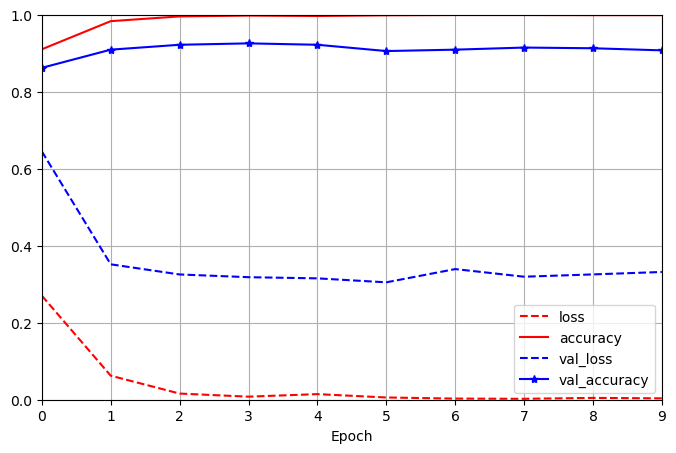

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(
    figsize = (8,5), xlim=[0,9], ylim=[0,1], grid=True, xlabel="Epoch",
    style=["r--", "r-", "b--", "b-*"]
)
plt.show()

### Classification and Localization
Localizing an objcet can be expressed as a regression task. The model needs to predict four members: horizontal & vertical coordinates, height and width. We just need to add second dense outout layer with four units (global average pooling layer), and it can be trained using MSE loss.

In [16]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = tf.keras.layers.Dense(4)(avg)

model = tf.keras.Model(inputs=base_model.input, outputs=[class_output, loc_output])

model.compile(
    loss = tf.keras.losses.sparse_categorical_crossentropy,
    loss_weights=[0.8, 0.2],
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    metrics=["accuracy"]
)

But now, we have a problem: the flowers dataset does not any bounding boxex around the boxes. So, we need to add them ourselves. To annotate images with bounfing boxes, you may want to use an open source image labeling tool like `VGG Image Annotator, 'LabelImg, OpenLabeler, ImgLab` or parhaps a commertial tool like `LabelNox` if have so many images.